# Homework 1

In [84]:
using JuMP
using Clp
using Plots
using RecipesBase
using NamedArrays

In [2]:
HOUR = collect(1:24)

24-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
 24

In [7]:
DISP = ["Nuclear", "Lignite", "Hard coal", "Natural gas"]
RES = ["Wind", "Solar"]
TECHNOLOGIES = vcat(DISP, RES, "Storage gen")

7-element Array{String,1}:
 "Nuclear"    
 "Lignite"    
 "Hard coal"  
 "Natural gas"
 "Wind"       
 "Solar"      
 "Storage gen"

In [8]:
demand = [60, 59, 56, 58, 64, 69, 79, 85, 81, 79, 78, 78, 80, 81, 82, 83, 84, 85, 89, 88, 86, 82, 80, 71]

24-element Array{Int64,1}:
 60
 59
 56
 58
 64
 69
 79
 85
 81
 79
 78
 78
 80
 81
 82
 83
 84
 85
 89
 88
 86
 82
 80
 71

## Calculate the marginal cost

 Technology | Fuel cost | $\eta$ | O&M | $\lambda$
-----|----------------|--------------
 Nuclear   |        3.00       |       0.33 | 10 | 0
 Lignite   |        6.21      |       0.42 | 6 | 0.399
 Hard coal   |       10.60       |      0.42 | 6 | 0.337
 Natural gas  |       31.08       |      0.59 | 2 | 0.201


Use this formula to calculate the marginal cost. The result should be a NamedArray with 4 elements. Assume the $ CO_{2}$ price to be 7 $\frac{EUR}{MWh}$.

$$ mc_p = \frac{\text{fuel_costs}_p}{\eta_p} + \text{co2_costs} \cdot \lambda_p + \text{om}_p$$

In [27]:
co_price = 7

7

Hint: Multiplying two vectors can be done by using `.*`.

In [50]:
c_fuel = NamedArray([3, 6.21, 10.6, 31.08], (DISP,), ("Technologies",))
eta    = NamedArray([0.33, 0.42, 0.42, 0.59], (DISP,), ("Technologies",))
om     = NamedArray([10, 6, 6, 2], (DISP,), ("Technologies",))
lambda = NamedArray([0, 0.399, 0.337, 0.201], (DISP,), ("Technologies",))

4-element Named Array{Float64,1}
Technologies  │ 
──────────────┼──────
Nuclear       │   0.0
Lignite       │ 0.399
Hard coal     │ 0.337
Natural gas   │ 0.201

In [95]:
mc     = c_fuel./eta + co_price.*lambda + om 

4-element Named Array{Float64,1}
Technologies  │ 
──────────────┼────────
Nuclear       │ 19.0909
Lignite       │ 23.5787
Hard coal     │ 33.5971
Natural gas   │  56.085

## Run the model

From here on, use the model that was discussed in the class.

In [10]:
g_max = NamedArray([20, 30, 25, 15], (DISP,), ("Technologies",))

4-element Named Array{Int64,1}
Technologies  │ 
──────────────┼───
Nuclear       │ 20
Lignite       │ 30
Hard coal     │ 25
Natural gas   │ 15

In [12]:
solar_availability = [
0
0
0
0.004
0.027
0.071
0.129
0.2
0.281
0.377
0.429
0.433
0.364
0.287
0.197
0.113
0.04
0.001
0
0
0
0
0
0
]

wind_availability = [
0.323
0.337
0.354
0.385
0.402
0.395
0.379
0.378
0.372
0.369
0.379
0.386
0.375
0.344
0.299
0.259
0.233
0.209
0.152
0.098
0.085
0.089
0.113
0.155
]

24-element Array{Float64,1}:
 0.323
 0.337
 0.354
 0.385
 0.402
 0.395
 0.379
 0.378
 0.372
 0.369
 0.379
 0.386
 0.375
 0.344
 0.299
 0.259
 0.233
 0.209
 0.152
 0.098
 0.085
 0.089
 0.113
 0.155

In [14]:
installed_solar = 25
installed_wind = 40

40

In [16]:
res_infeed = hcat(wind_availability*installed_wind, solar_availability*installed_solar)'
g_res = NamedArray(res_infeed, (RES,HOUR), ("Renewable Energy Source", "Hour"))

2×24 Named Array{Float64,2}
Renewable Energy Source ╲ Hour │      1       2  …      23      24
───────────────────────────────┼──────────────────────────────────
Wind                           │  12.92   13.48  …    4.52     6.2
Solar                          │    0.0     0.0  …     0.0     0.0

In [18]:
storage_max = 15
storage_gen = 5

5

In [19]:
dispatch_problem = Model(solver=ClpSolver())

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is ClpMathProg

In [20]:
@variables dispatch_problem begin       
        G[DISP, HOUR] >= 0 # generation from power plants
        G_stor[HOUR] >= 0 #generation from storage
        L[HOUR] >= 0 #current storage level
        D_stor[HOUR] >= 0 #consumption from storage 
end

In [23]:
JuMP.fix(L[1], 0)
JuMP.fix(L[24], 0)
JuMP.fix(G_stor[1], 0)

0

Objective function
$$ \sum_{DISP} \sum_{HOUR} mc_{disp} * G_{disp, hour} $$

In [52]:
@objective(dispatch_problem, Min, 
    sum(mc[disp] * G[disp, hour] for disp in DISP, hour in HOUR));

s.t.

$$ \sum_{DISP} G^{disp}_{hour} + G^{stor}_{hour} + \sum_{RES} g^{res}_{hour} = D^{stor} + demand_{hour} \quad \forall hour \in HOUR $$

In [53]:
@constraint(dispatch_problem, Market_Clearing[hour=HOUR],
    sum(G[disp, hour] for disp in DISP)
    + sum(g_res[res, hour] for res in RES)
    + G_stor[hour]
    ==
    demand[hour] 
    + D_stor[hour]
);

$$ G^{disp}_{hour} \le g^{max}_{disp} \quad \forall disp \in DISP, hour \in HOUR$$

In [54]:
@constraint(dispatch_problem, Max_Generation[disp=DISP, hour=HOUR],
    G[disp, hour] <= g_max[disp]
);

$$ L_{hour} = L_{hour - 1} + 0.88 * D^{stor}_{hour} - G^{stor}_{hour} \quad \forall hour \in HOUR_{2,...,24} $$

In [55]:
@constraint(dispatch_problem, Storage_Level[hour=HOUR; hour != 1],
    L[hour] == L[hour-1] + 0.88*D_stor[hour] - G_stor[hour]
);

$$ L_{hour} \le stor^{max} \quad \forall hour \in HOUR$$ 

In [56]:
@constraint(dispatch_problem, Max_Storage_Level[hour=HOUR],
    L[hour] <= storage_max
);

$$ G^{stor}_{hour} \le stor^{gen} \quad \forall hour \in HOUR$$ 

In [57]:
@constraint(dispatch_problem, Max_Storage_Generation[hour=HOUR],
    G_stor[hour] <= storage_gen
);

$$ D^{stor}_{hour} \le stor^{gen} \quad \forall hour \in HOUR$$ 

In [58]:
@constraint(dispatch_problem, Max_Storage_Withdraw[hour=HOUR],
    D_stor[hour] <= storage_gen
);

In [59]:
solve(dispatch_problem)

:Optimal

## Results

`vcat` concatenates the matrix G and the renewable infeed vertically. The  `'` transposes the matrix

In [60]:
result = vcat(getvalue(G).innerArray, g_res, getvalue(G_stor).innerArray')'

24×7 Array{Float64,2}:
 20.0  27.08     0.0    0.0    12.92   0.0    0.0
 20.0  29.8105   0.0    0.0    13.48   0.0    0.0
 20.0  26.84     0.0    0.0    14.16   0.0    0.0
 20.0  27.5      0.0    0.0    15.4    0.1    0.0
 20.0  30.0      0.0    0.0    16.08   0.675  0.0
 20.0  30.0      1.425  0.0    15.8    1.775  0.0
 20.0  30.0     10.615  0.0    15.16   3.225  0.0
 20.0  30.0     14.88   0.0    15.12   5.0    0.0
 20.0  30.0      9.095  0.0    14.88   7.025  0.0
 20.0  30.0      4.815  0.0    14.76   9.425  0.0
 20.0  30.0      2.115  0.0    15.16  10.725  0.0
 20.0  30.0      1.735  0.0    15.44  10.825  0.0
 20.0  30.0      5.9    0.0    15.0    9.1    0.0
 20.0  30.0     10.065  0.0    13.76   7.175  0.0
 20.0  30.0     15.115  0.0    11.96   4.925  0.0
 20.0  30.0     19.815  0.0    10.36   2.825  0.0
 20.0  30.0     23.68   0.0     9.32   1.0    0.0
 20.0  30.0     25.0    1.615   8.36   0.025  0.0
 20.0  30.0     25.0    2.92    6.08   0.0    5.0
 20.0  30.0     25.0    4.0

In [61]:
generation = NamedArray(result, (HOUR, TECHNOLOGIES), ("Hour", "Technology"))

24×7 Named Array{Float64,2}
Hour ╲ Technology │     Nuclear      Lignite  …        Solar  Storage gen
──────────────────┼──────────────────────────────────────────────────────
1                 │        20.0        27.08  …          0.0          0.0
2                 │        20.0      29.8105             0.0          0.0
3                 │        20.0        26.84             0.0          0.0
4                 │        20.0         27.5             0.1          0.0
5                 │        20.0         30.0           0.675          0.0
6                 │        20.0         30.0           1.775          0.0
7                 │        20.0         30.0           3.225          0.0
8                 │        20.0         30.0             5.0          0.0
9                 │        20.0         30.0           7.025          0.0
10                │        20.0         30.0           9.425          0.0
11                │        20.0         30.0          10.725          0.0
12        

In [62]:
storage_withdraw = -getvalue(D_stor).innerArray

24-element Array{Float64,1}:
 -0.0    
 -4.29045
 -5.0    
 -5.0    
 -2.755  
 -0.0    
 -0.0    
 -0.0    
 -0.0    
 -0.0    
 -0.0    
 -0.0    
 -0.0    
 -0.0    
 -0.0    
 -0.0    
 -0.0    
 -0.0    
 -0.0    
 -0.0    
 -0.0    
 -0.0    
 -0.0    
 -0.0    

In [63]:
storage_level = getvalue(L).innerArray

24-element Array{Float64,1}:
  0.0   
  3.7756
  8.1756
 12.5756
 15.0   
 15.0   
 15.0   
 15.0   
 15.0   
 15.0   
 15.0   
 15.0   
 15.0   
 15.0   
 15.0   
 15.0   
 15.0   
 15.0   
 10.0   
  5.0   
  0.0   
  0.0   
  0.0   
  0.0   

In [65]:
@userplot Areaplot
@recipe function f(a::Areaplot)
    data = cumsum(a.args[1], 2)

    seriestype := :line
    fillrange := 0

    @series begin
        data[:,1]
    end

    for i in 2:size(data, 2)
    @series begin
            fillrange := data[:,i-1]
            data[:,i]
        end
    end
end

You can also save plots in common formats like pdf, png or svg using the `savefig()` function.

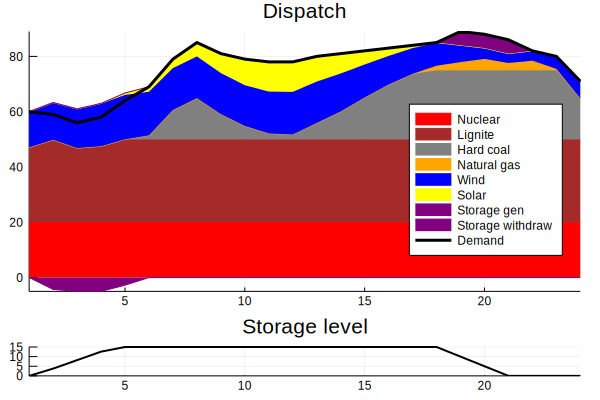

In [71]:
l = @layout([a{0.9h};b])
dispatch_plot = areaplot(generation, label=TECHNOLOGIES, title="Dispatch",
    color=reshape([:red, :brown, :grey, :orange, :blue, :yellow, :purple],1, length(TECHNOLOGIES)),
    legend=:bottomleft)
plot!(dispatch_plot, storage_withdraw, fill=0, label="Storage withdraw", color=:purple)
plot!(dispatch_plot, demand, c=:black, label="Demand", width=3, legend=:bottomright)

level_plot = plot(storage_level, width=2, color=:black, legend=false, title="Storage level")

    
plot(dispatch_plot,level_plot, layout=l)

In [ ]:
savefig("dispatch.pdf")
savefig("dispatch.png")
savefig("dispatch.svg")